In [107]:
import json
import shutil
import random
import pathlib
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import IPython.display as display

import mlflow
import mlflow.tensorflow
import mlflow.keras

import tensorflow as tf

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.losses import MSE, MSLE
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from xebikart.images import transformer as T
import xebikart.dataset as dataset

from sklearn.model_selection import train_test_split

%matplotlib inline

In [108]:
tf.__version__

'1.14.0'

In [109]:
tf.test.is_gpu_available()

False

Eager Execution allows to evaluate operations immediately without building graphs
note : Only needed when not using TF 2.0

In [110]:
tf.enable_eager_execution()

In [111]:
# parameters
# dataset parameters
tubes_root_folder = "file:/workspace/xebikart-ml-tubes"
#tubes_folders = ["tub.v4.02", "tub.v4.03", "tub.v5.01"]
tubes_folders_strips = ["tub_18_19-11-12", "tub_19_19-11-12"]
tubes_folders = tubes_folders_strips #+ ["tub_14_19-11-12","tub_17_19-11-12"]

test_size=0.2

# training parameters
batch_size = 16
shuffle_size = 200
n_epochs = 50
learning_rate = 1e-4

# Load data

Download tubes from : https://github.com/xebia-france/xebikart-ml-tubes

In [112]:
raw_tubes_df = dataset.get_tubes_df(tubes_root_folder, tubes_folders, tubes_extension=".tar.gz")
tubes_df = raw_tubes_df.rename(columns={"cam/image_array": "images_path", "user/angle": "angles", "user/throttle": "throttles"})
tubes_df.count()

images_path    2002
angles         2002
throttles      2002
num_tube       2002
dtype: int64

# Load data

#### **- Display some examples**

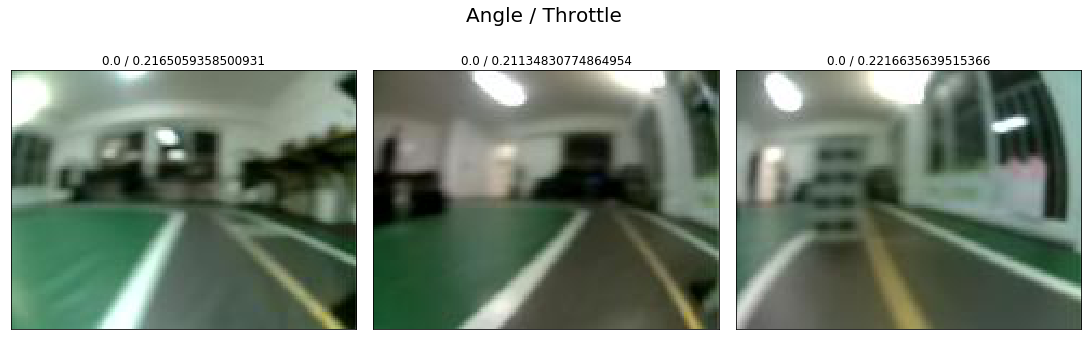

In [113]:
fig, axs = plt.subplots(1, 3, figsize=(15,5), constrained_layout=True)
fig.suptitle("Angle / Throttle", fontsize=20)

for n, sample in tubes_df.sample(3).reset_index().iterrows():
    random_image_path = sample["images_path"]
    angle = sample["angles"]
    throttle = sample["throttles"]
    image = mpimg.imread(random_image_path) 
    axs[n].set_title(f"{angle} / {throttle}")
    axs[n].imshow(image)
    axs[n].get_xaxis().set_visible(False)
    axs[n].get_yaxis().set_visible(False)

#### **- Display some sample distribution**

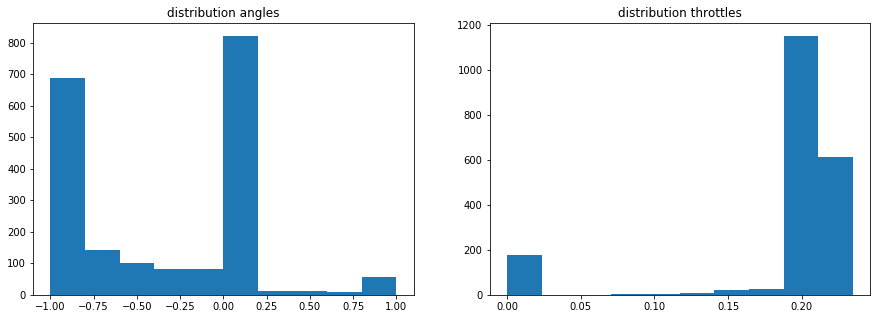

In [114]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].hist(tubes_df.angles)
axs[0].set_title('distribution angles')
axs[1].hist(tubes_df.throttles)
axs[1].set_title('distribution throttles')

plt.show()

# Preprocessing Images

**Images will be :**
- Loaded
    - Read images
    - Decode jpeg images into uint8 tensor
- Cropped
    - Crop images on the lower part
- Augmented
    - Brightness : Adjust the brightness of images by a random factor.
    - Saturation : Adjust the saturation of images by a random factor (must be RGB images)
    - Contrast : Adjust the contrast of images by a random factor.
    - Jpeg quality : Randomly changes jpeg encoding quality for inducing jpeg noise
- Normalized
    - Image are converted into Float32 between 0 and 1
- Edged
    - Convert tensor uint8 type into float32 type
    - Convert rgb images to grayscale
    - Reshape into [1, 80, 160, 1] tensor
    - Apply sobel filter (see https://en.wikipedia.org/wiki/Sobel_operator)
    - Reshape into [80, 160, 2] tensor
    - Select image gradient up to 0.3
    - Binarize images by setting elements to 0 or 1

##### **- Display some examples before and after preprocessing**

In [115]:
crop_fn = T.generate_crop_fn(left_margin=0, width=160, height_margin=40, height=80)

def load_augmentation_preprocess(image_path):
    tf_image = T.read_image(image_path)
    tf_image = T.normalize(tf_image)
    tf_image = crop_fn(tf_image)
    #tf_image = T.data_augmentation(tf_image)
    tf_image = T.edges(tf_image)
    return tf_image

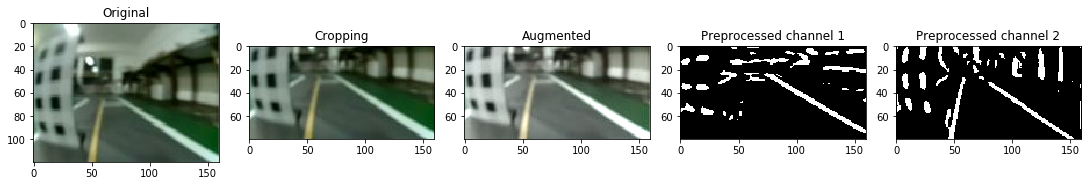

In [116]:
random_image_path = tubes_df.sample()["images_path"].values[0]

tf_image_original   = T.read_image(random_image_path)
tf_image_cropped    = crop_fn(tf_image_original)
tf_image_augmented  = T.data_augmentation(tf_image_cropped)
tf_image_normalized = T.normalize(tf_image_augmented)
tf_image_edged      = T.edges(tf_image_normalized)

fig, axs = plt.subplots(1, 5, figsize=(15,15), constrained_layout=True)
axs[0].set_title("Original")
axs[0].imshow(tf_image_original)
axs[1].set_title("Cropping")
axs[1].imshow(tf_image_cropped)
axs[2].set_title("Augmented")
axs[2].imshow(tf_image_augmented)
axs[3].set_title("Preprocessed channel 1")
axs[3].imshow(tf_image_edged[:,:,0],cmap='gray')
axs[4].set_title("Preprocessed channel 2")
axs[4].imshow(tf_image_edged[:,:,1],cmap='gray')
plt.show()

# Build a dataset of images

#### **- Split data into test/train datasets**

Note : We only use angle as label

In [117]:
images_path = tubes_df["images_path"].tolist()
metas_angle = tubes_df["angles"].tolist()
metas_throttle = tubes_df["throttles"].tolist()

In [118]:
train_images_path, test_images_path, train_metas, test_metas = train_test_split(images_path, metas_angle, test_size=test_size)
print('Train set :', len(train_images_path), 'images')
print('Test set :', len(test_images_path), 'images')

Train set : 1601 images
Test set : 401 images


#### **- Create tensor for train and test datasets**

In [119]:
def input_fn(filepath, label, BATCH_SIZE = 32, SHUFFLE_SIZE = 200, NUM_EPOCHS = 200):
    ds_x = tf.data.Dataset.from_tensor_slices(filepath)
    ds_x = ds_x.map(load_augmentation_preprocess)
    ds_y = tf.data.Dataset.from_tensor_slices(label)
    ds_x_y = tf.data.Dataset.zip((ds_x, ds_y)).shuffle(SHUFFLE_SIZE).repeat(NUM_EPOCHS).batch(BATCH_SIZE).prefetch(1)
    
    return ds_x_y

In [120]:
ds_train = input_fn(train_images_path, train_metas)
ds_test = input_fn(test_images_path, test_metas)

# Build Model

In [121]:
model = Sequential()

model.add(Conv2D(16, (5,5), activation='relu', kernel_regularizer=l1_l2(l1=0.1, l2=0.01), input_shape=(80, 160, 2)))
model.add(MaxPooling2D(3,3))
model.add(Conv2D(32, (3,3), activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(MaxPooling2D(3,3))
model.add(Conv2D(64, (3,3), activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 76, 156, 16)       816       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 25, 52, 16)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 23, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 7, 16, 32)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 5, 14, 64)         18496     
_________________________________________________________________
flatten_5 (Flatten)          (None, 4480)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)              

In [122]:
model.compile(optimizer=Adam(learning_rate=learning_rate, decay=1e-6), loss="mean_squared_error")

**- How to choose and interpret loss :**

Mean Absolute Error (MAE) is the absolute value of the substraction of predicted from actual value
Let's see an example : 
Actual angle = 0.21


In [123]:
mlflow.set_experiment("drive_auto_takeover_ml_only_strips")

with mlflow.start_run():
    mlflow.log_params({
        "images": str(tubes_folders),
        "nb_images": len(train_images_path),
        "epochs": n_epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate
    })
    mlflow.tensorflow.autolog()
    history = model.fit(x=ds_train,
                    steps_per_epoch=len(train_metas)//batch_size,
                    epochs=n_epochs,
                    verbose=1,
                    validation_data=ds_test,
                    validation_steps=len(test_metas)//batch_size)

Epoch 1/50
100/100 [==============================] - 44s 438ms/step - loss: 14.5433 - val_loss: 13.0288
Epoch 2/50
100/100 [==============================] - 36s 361ms/step - loss: 11.7276 - val_loss: 10.3988
Epoch 3/50
100/100 [==============================] - 33s 331ms/step - loss: 9.2491 - val_loss: 8.0940
Epoch 4/50
100/100 [==============================] - 35s 355ms/step - loss: 7.1008 - val_loss: 6.1067
Epoch 5/50
100/100 [==============================] - 35s 345ms/step - loss: 5.2643 - val_loss: 4.4377
Epoch 6/50
100/100 [==============================] - 18s 177ms/step - loss: 3.7576 - val_loss: 3.0999
Epoch 7/50
100/100 [==============================] - 23s 234ms/step - loss: 2.5722 - val_loss: 2.0647
Epoch 8/50
100/100 [==============================] - 23s 228ms/step - loss: 1.6863 - val_loss: 1.3262
Epoch 9/50
100/100 [==============================] - 22s 221ms/step - loss: 1.0765 - val_loss: 0.8422
Epoch 10/50
100/100 [==============================] - 22s 216ms/step

In [124]:
# load model
# cnn_model = mlflow.keras.load_model("runs:/5d890004534c44f1880a0da3011c80d0/model")

# Plot loss

In [125]:
def plot_results(history):
    hist_df = pd.DataFrame(history.history)
    hist_df.columns=['loss','val_loss']
    hist_df.index = np.arange(1, len(hist_df)+1)
    fig = plt.figure(figsize=(10,5))
    plt.plot(hist_df.val_loss, lw=3, label='Validation Loss')
    plt.plot(hist_df.loss, lw=3, label='Training Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.legend(loc=0)

    plt.show()

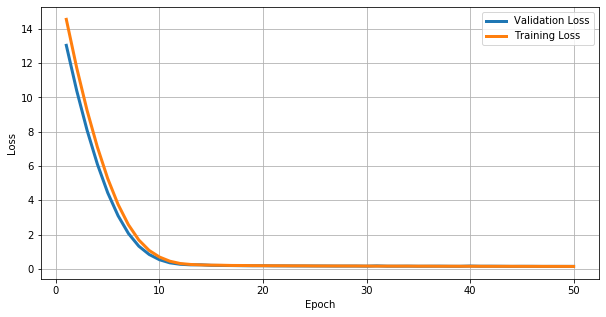

In [126]:
plot_results(history)

# Evaluation

**- steps:** Total number of steps (batches of samples) before declaring the prediction round finished. Ignored with the default value of None. If x is a tf.data dataset or a dataset iterator, and steps is None, predict will run until the input dataset is exhausted.

In [127]:
train_angles = model.predict(ds_test, steps=len(test_metas)//batch_size)

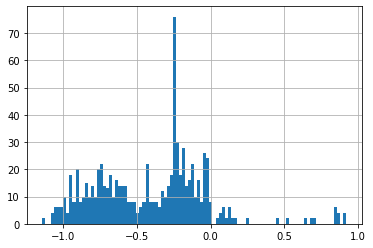

In [128]:
df = pd.DataFrame(train_angles, columns = ['angles'])
df.angles.hist(bins=100)

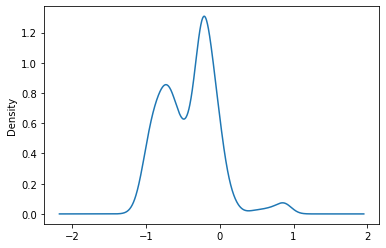

In [129]:
df.angles.plot.kde()